In [1]:
!pip install librosa
!pip install jiwer
!pip install tqdm
!pip install torch
import os
import tarfile
import librosa
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from jiwer import wer, cer
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import string
import urllib

In [2]:
# Define download URLs
urls = [
    "https://www.cs.toronto.edu/~complingweb/data/TORGO/F.tar.bz2",
    "https://www.cs.toronto.edu/~complingweb/data/TORGO/FC.tar.bz2",
    "https://www.cs.toronto.edu/~complingweb/data/TORGO/M.tar.bz2",
    "https://www.cs.toronto.edu/~complingweb/data/TORGO/MC.tar.bz2"
]

In [3]:
# Set up directories
data_dir = Path("torgo_data")
downloads_dir = data_dir / "downloads"
extract_dir = data_dir / "extracted"

downloads_dir.mkdir(parents=True, exist_ok=True)
extract_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Download archives if not already present
for url in urls:
    filename = url.split("/")[-1]
    filepath = downloads_dir / filename
    if not filepath.exists():
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
    else:
        print(f"{filename} already downloaded.")

F.tar.bz2 already downloaded.
FC.tar.bz2 already downloaded.
M.tar.bz2 already downloaded.
MC.tar.bz2 already downloaded.


In [5]:
# Extract archives
for file in downloads_dir.glob("*.tar.bz2"):
    print(f"Extracting {file.name}...")
    with tarfile.open(file, "r:bz2") as tar:
        tar.extractall(path=extract_dir)

Extracting F.tar.bz2...


/var/folders/f0/wrmnpm7j7kx14k9b5mvxkg0m0000gn/T/ipykernel_49909/4222748948.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Extracting MC.tar.bz2...
Extracting FC.tar.bz2...
Extracting M.tar.bz2...


In [6]:
# Filter and pair WAV files with valid prompt text files
pairs = []

def is_valid_prompt(txt_path):
    try:
        content = txt_path.read_text().strip().lower()
        return 'xxx' not in content and '.jpg' not in content
    except:
        return False  # skip unreadable files

for session_dir in extract_dir.rglob("Session*"):
    prompt_dir = session_dir / "prompts"
    if not prompt_dir.exists():
        continue

    # Get valid prompts
    prompt_map = {
        p.stem: p for p in prompt_dir.glob("*.txt") if is_valid_prompt(p)
    }

    for wav_dir in session_dir.glob("wav_*"):
        for wav_file in wav_dir.glob("*.wav"):
            utt_id = wav_file.stem
            prompt_file = prompt_map.get(utt_id)
            if prompt_file:
                pairs.append((wav_file, prompt_file))

print(f"Found {len(pairs)} usable (wav, prompt) pairs.")

Found 16958 usable (wav, prompt) pairs.


In [7]:
# Show some sample pairs
for i, (wav, prompt) in enumerate(pairs[:5]):
    print(f"Pair {i+1}: {wav} <-> {prompt}")

Pair 1: torgo_data/extracted/MC02/Session2/wav_arrayMic/0164.wav <-> torgo_data/extracted/MC02/Session2/prompts/0164.txt
Pair 2: torgo_data/extracted/MC02/Session2/wav_arrayMic/0170.wav <-> torgo_data/extracted/MC02/Session2/prompts/0170.txt
Pair 3: torgo_data/extracted/MC02/Session2/wav_arrayMic/0158.wav <-> torgo_data/extracted/MC02/Session2/prompts/0158.txt
Pair 4: torgo_data/extracted/MC02/Session2/wav_arrayMic/0010.wav <-> torgo_data/extracted/MC02/Session2/prompts/0010.txt
Pair 5: torgo_data/extracted/MC02/Session2/wav_arrayMic/0038.wav <-> torgo_data/extracted/MC02/Session2/prompts/0038.txt


## Normalize Data

In [8]:
# Paths
extract_dir = Path("torgo_data/extracted")
output_dir = Path("torgo_dataset")
output_dir.mkdir(exist_ok=True)

# Metadata and feature storage
metadata = []
features_dir = output_dir / "mel_spectrograms"
features_dir.mkdir(exist_ok=True)

dysarthric_sources = {"F", "M"}  # dysarthric speakers

def normalize_text(text):
    text = text.strip().lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def is_valid_prompt(txt_path):
    try:
        content = txt_path.read_text().strip().lower()
        return 'xxx' not in content and '.jpg' not in content
    except:
        return False

def get_transcription(txt_path):
    return normalize_text(txt_path.read_text().strip())

def get_speaker_info(path):
    parts = path.parts
    for part in parts:
        if part.startswith(("F", "M")) and len(part) == 4:
            gender = part[0]
            has_dysarthria = part[:2] in dysarthric_sources
            return gender, has_dysarthria
    return None, None

def wav_to_mel(path, sr=16000, n_mels=80):
    y, _ = librosa.load(path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

In [9]:
# Convert dataset
for session_dir in tqdm(list(extract_dir.rglob("Session*")), desc="Processing sessions"):
    prompt_dir = session_dir / "prompts"
    if not prompt_dir.exists():
        continue

    prompt_map = {
        p.stem: p for p in prompt_dir.glob("*.txt") if is_valid_prompt(p)
    }

    for wav_dir in session_dir.glob("wav_*"):
        for wav_file in wav_dir.glob("*.wav"):
            utt_id = wav_file.stem
            prompt_file = prompt_map.get(utt_id)
            if prompt_file:
                gender, has_dysarthria = get_speaker_info(wav_file)
                if gender is None:
                    continue

                try:
                    mel_spec = wav_to_mel(wav_file)
                    npy_path = features_dir / f"{wav_file.stem}_{gender}.npy"
                    np.save(npy_path, mel_spec)

                    metadata.append({
                        "mel_path": str(npy_path.resolve()),
                        "transcript": get_transcription(prompt_file),
                        "has_dysarthria": has_dysarthria,
                        "gender": gender
                    })
                except Exception as e:
                    print(f"Error processing {wav_file}: {e}")

df = pd.DataFrame(metadata)
df.to_csv(output_dir / "metadata.csv", index=False)
print(f"\nSaved {len(df)} samples to {output_dir}")

Processing sessions: 100%|██████████| 30/30 [00:26<00:00,  1.14it/s]


Saved 11184 samples to torgo_dataset


## Disfluency CTC Model Building

In [10]:
# Dataset & Collate
class TorgoSpeechDataset(Dataset):
    def __init__(self, metadata_csv, max_len=512):
        self.df = pd.read_csv(metadata_csv)
        self.char_to_idx = self._build_vocab()
        self.max_len = max_len

    def _build_vocab(self):
        vocab = sorted(set("".join(self.df.transcript.tolist())))
        vocab.append("[DISFL]")  # include disfluency token in vocab
        return {ch: i + 1 for i, ch in enumerate(vocab)}  # 0 = CTC blank

    def _text_to_sequence(self, text):
        return [self.char_to_idx.get(ch, 0) for ch in text.lower()][:self.max_len]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mel = np.load(row.mel_path)
        mel_tensor = torch.tensor(mel.T, dtype=torch.float32)
        transcript = self._text_to_sequence(row.transcript)
        return {
            "mel": mel_tensor,
            "transcript": torch.tensor(transcript, dtype=torch.long),
            "mel_len": mel_tensor.shape[0],
            "transcript_len": len(transcript)
        }

def collate_fn(batch):
    B = len(batch)
    feat_dim = batch[0]["mel"].shape[1]
    max_mel = max(x["mel_len"] for x in batch)
    max_txt = max(x["transcript_len"] for x in batch)

    mels = torch.zeros(B, max_mel, feat_dim)
    trans = torch.zeros(B, max_txt, dtype=torch.long)
    mel_lens = []
    trans_lens = []

    for i, b in enumerate(batch):
        mels[i, :b["mel_len"]] = b["mel"]
        trans[i, :b["transcript_len"]] = b["transcript"]
        mel_lens.append(b["mel_len"])
        trans_lens.append(b["transcript_len"])

    return {
        "mel": mels,
        "transcript": trans,
        "mel_lengths": torch.tensor(mel_lens),
        "transcript_lengths": torch.tensor(trans_lens)
    }

In [11]:
# Disfluency-Aware CTC Model
class DisfluencyAwareCTC(nn.Module):
    def __init__(self, input_dim, vocab_size):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, 256, 3, batch_first=True, bidirectional=True)
        self.blank_classifier = nn.Linear(512, 1)
        self.gap_detector = nn.Sequential(
            nn.Conv1d(512, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 2)
        )
        self.classifier = nn.Linear(512, vocab_size + 1)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.encoder(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        logits = self.classifier(out)
        gap_logits = self.gap_detector(out.transpose(1, 2))
        blank_probs = torch.sigmoid(self.blank_classifier(out)).squeeze(-1)
        return logits, gap_logits, blank_probs

In [12]:
# CTC Loss
def compute_disfluency_ctc_loss(logits, targets, input_lengths, target_lengths, blank=0):
    log_probs = F.log_softmax(logits, dim=-1).transpose(0, 1)
    return F.ctc_loss(log_probs, targets, input_lengths, target_lengths, blank=blank, zero_infinity=True)

In [13]:
# Decoding
def decode_disfluency_ctc_output(logits, idx_to_char, blank=0):
    pred_ids = torch.argmax(logits, dim=-1).cpu().numpy()
    outputs = []
    for pred in pred_ids:
        decoded = []
        prev = None
        for p in pred:
            if p != blank and p != prev:
                decoded.append(idx_to_char.get(p, ""))
            prev = p
        outputs.append(" ".join(decoded))
    return outputs

In [14]:
# Training
def train_disfluency_ctc(model, dataset, batch_size=16, epochs=50, patience=5, device='cpu'):
    idx_to_char = {v: k for k, v in dataset.char_to_idx.items()}
    train_len = int(0.8 * len(dataset))
    train_set, val_set = random_split(dataset, [train_len, len(dataset) - train_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses, val_losses, wer_scores, cer_scores = [], [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            x = batch["mel"].to(device)
            y = batch["transcript"].to(device)
            x_lens = batch["mel_lengths"].to(device)
            y_lens = batch["transcript_lengths"].to(device)

            logits, _, _ = model(x, x_lens)
            loss = compute_disfluency_ctc_loss(logits, y, x_lens, y_lens)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        refs, hyps = [], []
        with torch.no_grad():
            for batch in val_loader:
                x = batch["mel"].to(device)
                y = batch["transcript"].to(device)
                x_lens = batch["mel_lengths"].to(device)
                y_lens = batch["transcript_lengths"].to(device)

                logits, _, _ = model(x, x_lens)
                loss = compute_disfluency_ctc_loss(logits, y, x_lens, y_lens)
                val_loss += loss.item()

                decoded = decode_disfluency_ctc_output(logits, idx_to_char)
                for i in range(len(decoded)):
                    ref = "".join([idx_to_char.get(c.item(), "") for c in y[i, :y_lens[i]]])
                    refs.append(ref)
                    hyps.append(decoded[i])

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        wer_val = wer(refs, hyps)
        cer_val = cer(refs, hyps)
        wer_scores.append(wer_val)
        cer_scores.append(cer_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, WER = {wer_val:.3f}, CER = {cer_val:.3f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(wer_scores, label="WER")
    plt.plot(cer_scores, label="CER")
    plt.title("WER and CER per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Error Rate")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

Epoch 1: Train Loss = 4.1367, Val Loss = 3.6024, WER = 1.000, CER = 0.956
Epoch 2: Train Loss = 3.5995, Val Loss = 3.5503, WER = 1.016, CER = 0.956
Epoch 3: Train Loss = 3.5585, Val Loss = 3.5207, WER = 1.545, CER = 0.937
Epoch 4: Train Loss = 3.5429, Val Loss = 3.5150, WER = 1.272, CER = 0.923
Epoch 5: Train Loss = 3.5339, Val Loss = 3.5129, WER = 1.272, CER = 0.923
Epoch 6: Train Loss = 3.5335, Val Loss = 3.4949, WER = 1.000, CER = 0.954
Epoch 7: Train Loss = 3.5295, Val Loss = 3.5301, WER = 1.551, CER = 0.938
Epoch 8: Train Loss = 3.5303, Val Loss = 3.5128, WER = 1.438, CER = 0.941
Epoch 9: Train Loss = 3.5244, Val Loss = 3.5250, WER = 1.272, CER = 0.923
Early stopping triggered.


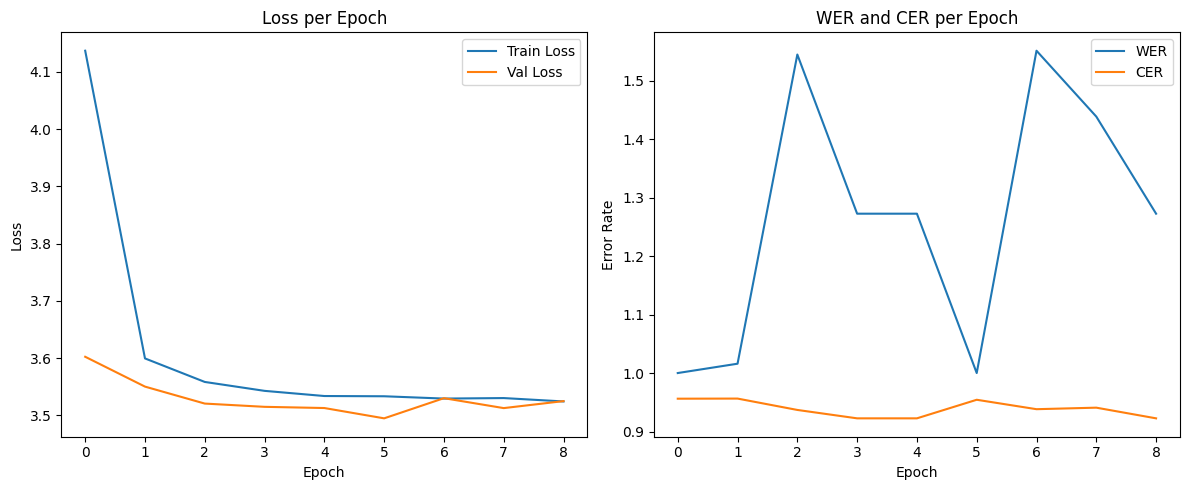

In [17]:
# Load dataset
dataset = TorgoSpeechDataset("torgo_dataset/metadata.csv")

# Create model
model = DisfluencyAwareCTC(input_dim=80, vocab_size=len(dataset.char_to_idx))

# Train model
trained_model = train_disfluency_ctc(
    model=model,
    dataset=dataset,
    batch_size=32,
    epochs=1000,
    patience=3,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)